<a href="https://colab.research.google.com/github/xrhd/sandbox/blob/main/1_projects/deep_q_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [28]:
!uv pip install jax gym numpy matplotlib pyvirtualdisplay --system

Using Python 3.11.11 environment at: /usr
Resolved 20 packages in 367ms
⠙ Preparing packages... (0/1)
⠙ Preparing packages... (0/1)
Prepared 1 package in 20ms
Installed 1 package in 3ms
 + pyvirtualdisplay==3.0


In [14]:
import numpy as np
import jax
import jax.numpy as jnp
from jax import grad, jit, random
import optax # Import optax directly
# from jax.experimental import stencil # This import remains the samel
import gym
from collections import deque
import matplotlib.pyplot as plt

from jax.nn import relu

In [5]:
env = gym.make('CartPole-v1')

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


# Model

In [15]:
def init_weights(rng, shape):
    """Initialize weights for a neural network layer."""
    scale = 2.0 / shape[0] ** 0.5
    weight = random.normal(rng, shape) * scale
    return weight

def neural_network(rng, input_shape, hidden_size=64, output_size=2):
    """Define a simple neural network with two hidden layers."""
    # Input layer
    rng, input_rng = random.split(rng)
    input_weights = init_weights(input_rng, (input_shape, hidden_size))
    input_bias = jnp.zeros((hidden_size,))

    # Hidden layer
    rng, hidden_rng = random.split(rng)
    hidden_weights = init_weights(hidden_rng, (hidden_size, hidden_size))
    hidden_bias = jnp.zeros((hidden_size,))

    # Output layer
    rng, output_rng = random.split(rng)
    output_weights = init_weights(output_rng, (hidden_size, output_size))
    output_bias = jnp.zeros((output_size,))

    return (input_weights, input_bias,
            hidden_weights, hidden_bias,
            output_weights, output_bias)

def forward_pass(params, x):
    """Forward pass of the neural network."""
    (input_weights, input_bias,
     hidden_weights, hidden_bias,
     output_weights, output_bias) = params

    # First hidden layer
    x = jnp.dot(x, input_weights) + input_bias
    # Use relu from jax.nn
    x = relu(x)

    # Second hidden layer
    x = jnp.dot(x, hidden_weights) + hidden_bias
    # Use relu from jax.nn
    x = relu(x)

    # Output layer
    x = jnp.dot(x, output_weights) + output_bias
    return x

# Initialize the neural network
rng = random.PRNGKey(0)
input_shape = env.observation_space.shape[0]
params = neural_network(rng, input_shape)

# Train

In [7]:
replay_buffer = deque(maxlen=10000)

In [8]:
gamma = 0.99
epsilon = 1.0
epsilon_min = 0.01
epsilon_decay = 0.995
batch_size = 64
update_target_every = 10
learning_rate = 0.001

In [9]:
def loss(params, batch):
    states = batch[0]
    actions = batch[1]
    rewards = batch[2]
    next_states = batch[3]
    dones = batch[4]

    # Get current Q-values
    q_values = forward_pass(params, states)

    # Get next Q-values
    next_q_values = forward_pass(params, next_states)

    # Calculate target Q-values
    target = rewards + gamma * (1 - dones) * jnp.max(next_q_values, axis=1)

    # Calculate loss
    loss = jnp.mean((q_values[jnp.arange(batch_size), actions] - target) ** 2)
    return loss

In [10]:
@jit
def update(params, opt_state, batch):
    grads = grad(loss)(params, batch)
    updates, opt_state = optax.adam(learning_rate).update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state

In [20]:
# Initialize the optimizer
opt_state = optax.adam(learning_rate).init(params)

# Initialize the best score
best_score = 0

# Initialize the episode rewards
episode_rewards = []

for episode in range(1000):
    state = env.reset()
    total_reward = 0
    done = False

    while not done:
        # Epsilon-greedy action selection
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else:
            # Convert state to JAX array
            state_jax = jnp.array([state])
            q_values = forward_pass(params, state_jax)
            # print(q_values[0].shape)
            # action = np.argmax(q_values[0])
            action = int(np.argmax(q_values[0]))

        # Take action in the environment
        next_state, reward, done, _ = env.step(action)

        # Store the experience in the replay buffer
        replay_buffer.append((state, action, reward, next_state, done))
        state = next_state
        total_reward += reward

        # Train the model
        if len(replay_buffer) >= batch_size:
            # Sample a batch from the replay buffer
            batch = np.random.choice(len(replay_buffer), batch_size, replace=False)
            batch = [replay_buffer[i] for i in batch]

            # Convert batch to JAX arrays
            states = jnp.array([x[0] for x in batch])
            actions = jnp.array([x[1] for x in batch])
            rewards = jnp.array([x[2] for x in batch])
            next_states = jnp.array([x[3] for x in batch])
            dones = jnp.array([x[4] for x in batch])

            # Update the model
            params, opt_state = update(params, opt_state, (states, actions, rewards, next_states, dones))

        # Decay epsilon
        if epsilon > epsilon_min:
            epsilon *= epsilon_decay

    # Update the best score
    if total_reward > best_score:
        best_score = total_reward

    # Append the episode reward
    episode_rewards.append(total_reward)

    # Print progress
    print(f'Episode: {episode+1}, Total Reward: {total_reward}, Best Score: {best_score}, Epsilon: {epsilon}')

Episode: 1, Total Reward: 12.0, Best Score: 12.0, Epsilon: 0.032109488810599975
Episode: 2, Total Reward: 49.0, Best Score: 49.0, Epsilon: 0.025116802354115567
Episode: 3, Total Reward: 17.0, Best Score: 49.0, Epsilon: 0.023065173234186005
Episode: 4, Total Reward: 40.0, Best Score: 49.0, Epsilon: 0.018874695352408037
Episode: 5, Total Reward: 17.0, Best Score: 49.0, Epsilon: 0.017332943577287888
Episode: 6, Total Reward: 13.0, Best Score: 49.0, Epsilon: 0.016239489508417658
Episode: 7, Total Reward: 77.0, Best Score: 77.0, Epsilon: 0.011039504743095268
Episode: 8, Total Reward: 9.0, Best Score: 77.0, Epsilon: 0.010552547534153616
Episode: 9, Total Reward: 14.0, Best Score: 77.0, Epsilon: 0.00998645168764533
Episode: 10, Total Reward: 91.0, Best Score: 91.0, Epsilon: 0.00998645168764533
Episode: 11, Total Reward: 19.0, Best Score: 91.0, Epsilon: 0.00998645168764533
Episode: 12, Total Reward: 12.0, Best Score: 91.0, Epsilon: 0.00998645168764533
Episode: 13, Total Reward: 25.0, Best Scor

KeyboardInterrupt: 

# Testing

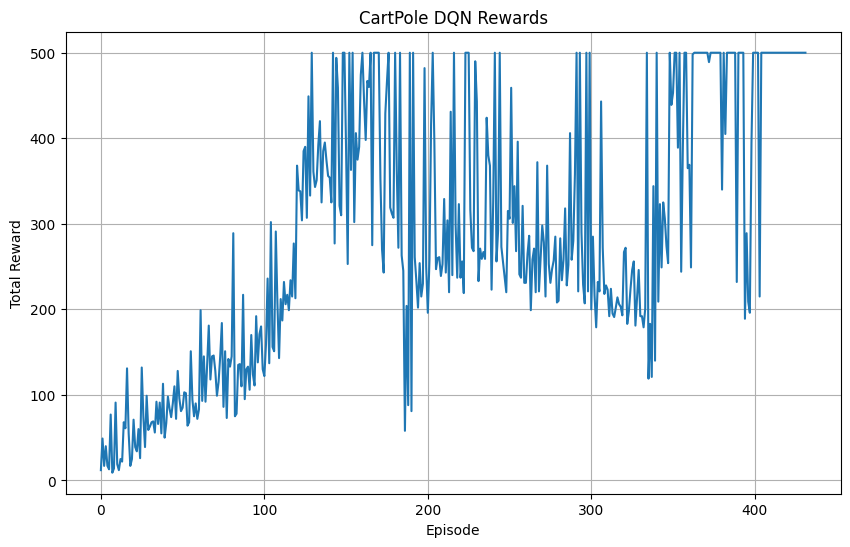

In [21]:
plt.figure(figsize=(10, 6))
plt.plot(episode_rewards)
plt.title('CartPole DQN Rewards')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.grid(True)
plt.show()

In [23]:
# Test the model
state = env.reset()
done = False
total_reward = 0

while not done:
    # Convert state to JAX array
    state_jax = jnp.array([state])
    q_values = forward_pass(params, state_jax)
    action = int(np.argmax(q_values[0]))

    # Take action in the environment
    next_state, reward, done, _ = env.step(action)
    state = next_state
    total_reward += reward

print(f'Test Episode Reward: {total_reward}')

Test Episode Reward: 233.0


In [38]:
screens = []
with gym.make(
    'CartPole-v1',
    # render_mode='human'
) as _env:
  state = _env.reset()
  done = False
  while not done:
      screens.append(_env.render(mode='rgb_array'))
      state_jax = jnp.array([state])
      q_values = forward_pass(params, state_jax)
      action = int(np.argmax(q_values[0]))
      state, _, done, _ = _env.step(action)

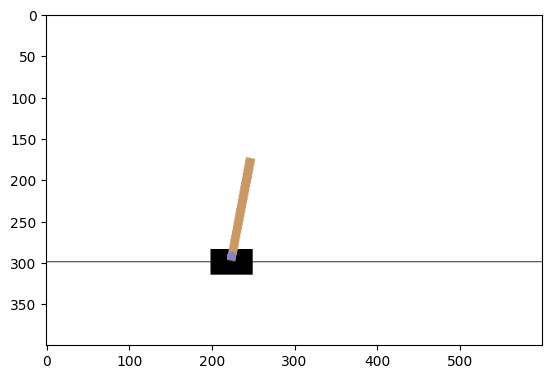

In [49]:
plt.imshow(screens[-1])

In [42]:
!uv pip install fastgif --system

Using Python 3.11.11 environment at: /usr
Resolved 13 packages in 496ms
   Building fastgif==2.1
   Building fastgif==2.1
   Building fastgif==2.1
   Building fastgif==2.1
   Building fastgif==2.1
   Building fastgif==2.1
      Built fastgif==2.1
Prepared 1 package in 1.00s
Installed 1 package in 1ms
 + fastgif==2.1


In [43]:
import fastgif

In [48]:
def foo(idx):
  fig, ax = plt.subplots(dpi=150)
  ax.imshow(screens[idx])
  return fig

fastgif.make_gif(foo, len(screens), 'carpole.gif', show_progress=True, writer_kwargs={'duration': 0.01})

/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.11/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.11/dist-packages/fastgif.py:100: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(os.path.join(where, f'{val}.png'))
